In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [40]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eunic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eunic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eunic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eunic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Lectura y limpieza

In [41]:
df = pd.read_csv('spam_ham.csv', sep=';', encoding='latin-1')
df['SMS_TEXT'] = df['SMS_TEXT'].astype(str)

In [42]:
df['Label'] = df['Label'].str.strip('"')

In [43]:
df = df.dropna(subset=['SMS_TEXT'])

# EDA

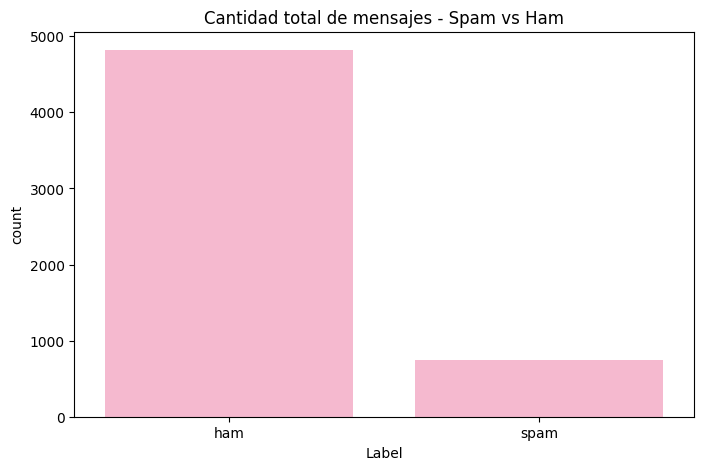

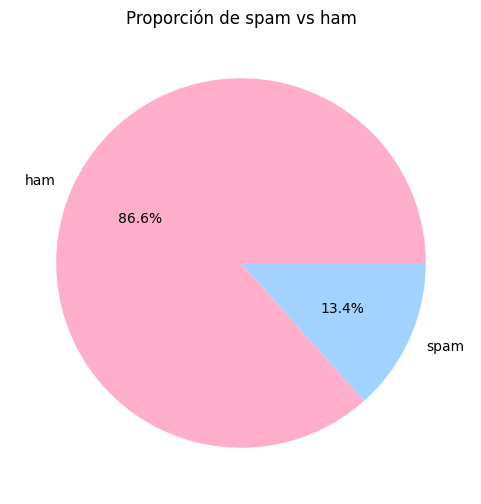

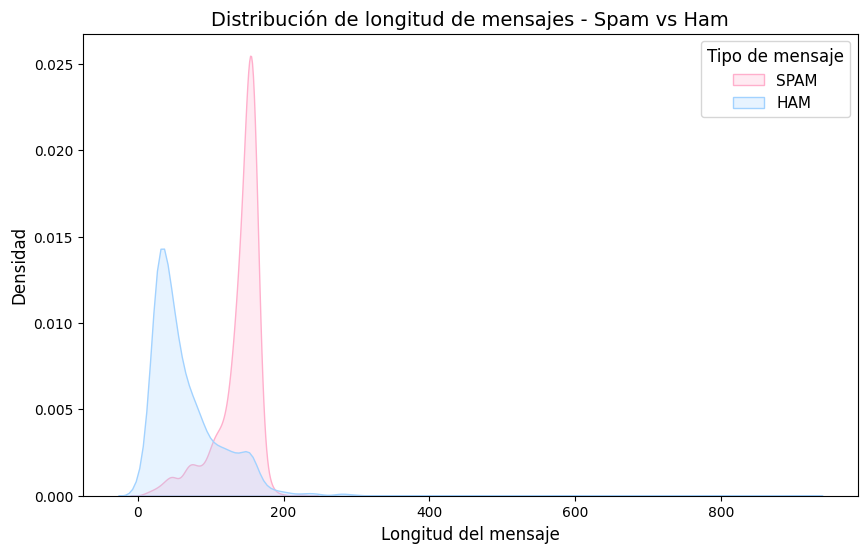

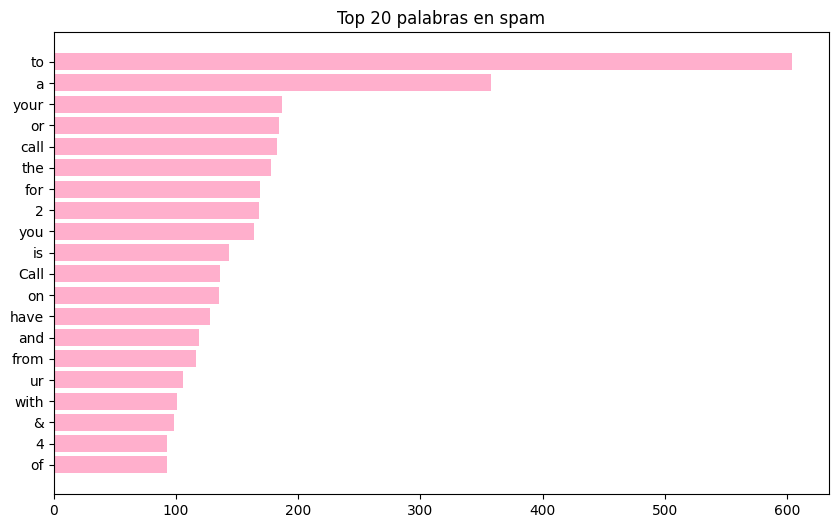

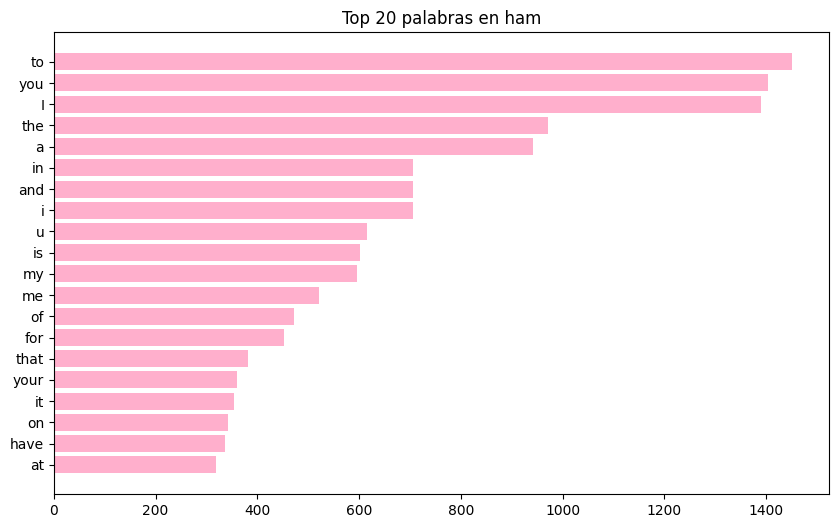

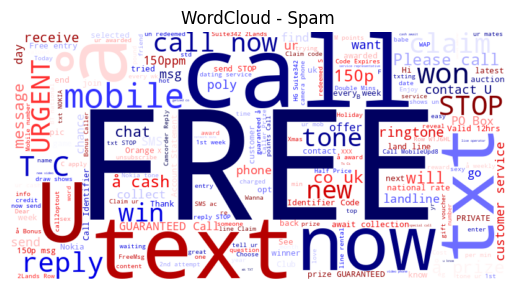

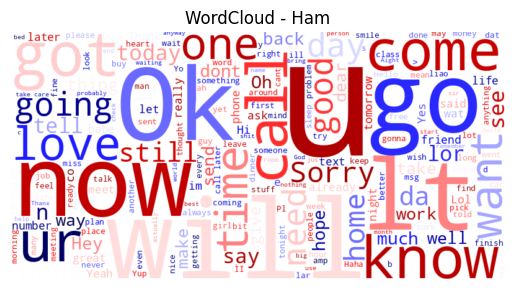

In [44]:
#cantidad total de cada mensaje
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Label', color='#ffafcc')
plt.title('Cantidad total de mensajes - Spam vs Ham')
plt.show()

#proporción de spam y ham
plt.figure(figsize=(6, 6))
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors= ["#ffafcc","#a2d2ff"])
plt.title('Proporción de spam vs ham')
plt.ylabel('')
plt.show()

#densidad de longitud de cada mensaje
df['Length'] = df['SMS_TEXT'].apply(len)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['Label'] == 'spam'], x='Length', color='#ffafcc', label='SPAM', fill=True)
sns.kdeplot(data=df[df['Label'] == 'ham'], x='Length', color='#a2d2ff', label='HAM', fill=True)
plt.title('Distribución de longitud de mensajes - Spam vs Ham', fontsize=14)
plt.xlabel('Longitud del mensaje', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Tipo de mensaje', title_fontsize=12, fontsize=11)
plt.show()

#20 palabras más frecuentes
def plot_top_words(text_series, title):
    words = ' '.join(text_series).split()
    freq_dist = nltk.FreqDist(words)
    top_words = freq_dist.most_common(20)
    plt.figure(figsize=(10, 6))
    plt.barh([word[0] for word in top_words], [word[1] for word in top_words], color='#ffafcc')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
plot_top_words(df[df['Label'] == 'spam']['SMS_TEXT'], 'Top 20 palabras en spam')
plot_top_words(df[df['Label'] == 'ham']['SMS_TEXT'], 'Top 20 palabras en ham')

#wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="seismic_r").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
generate_wordcloud(' '.join(df[df['Label'] == 'spam']['SMS_TEXT']), 'WordCloud - Spam')
generate_wordcloud(' '.join(df[df['Label'] == 'ham']['SMS_TEXT']), 'WordCloud - Ham')

In [45]:
def preprocess_text(text):
    tokens = word_tokenize(text) 
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in string.punctuation] 
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)
df['Processed_Text'] = df['SMS_TEXT'].apply(preprocess_text)

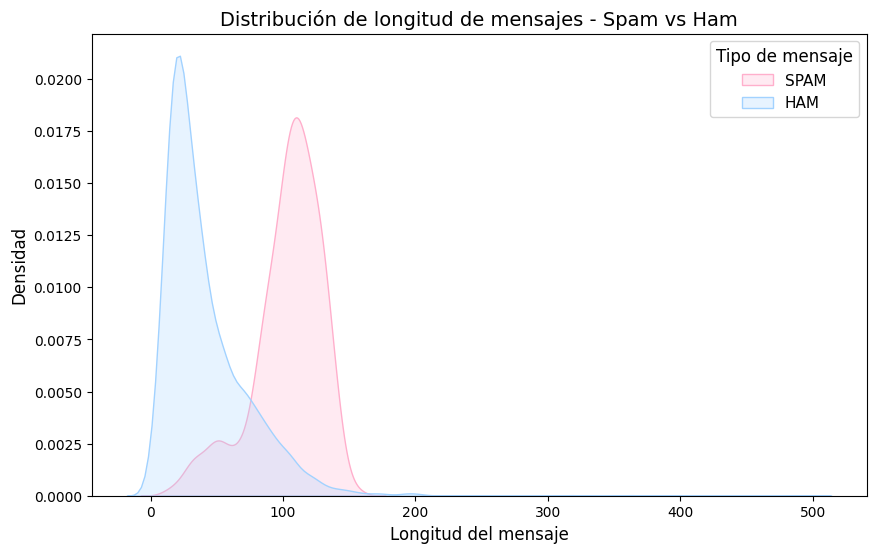

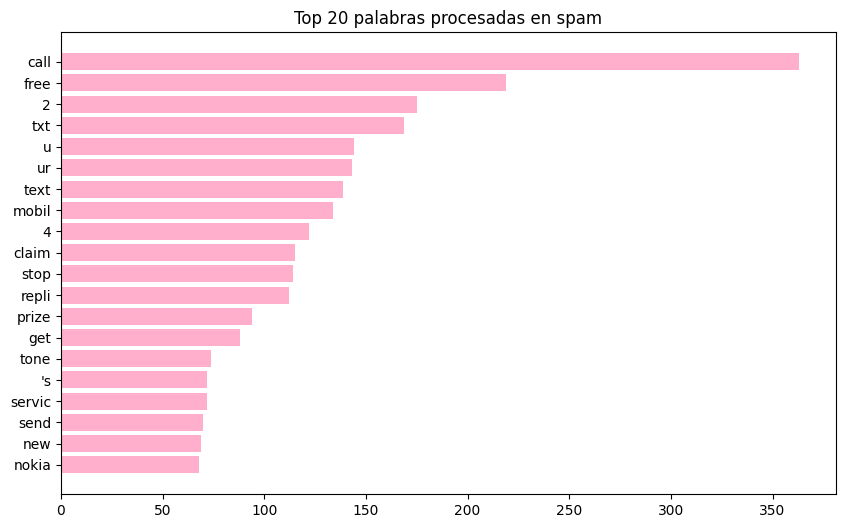

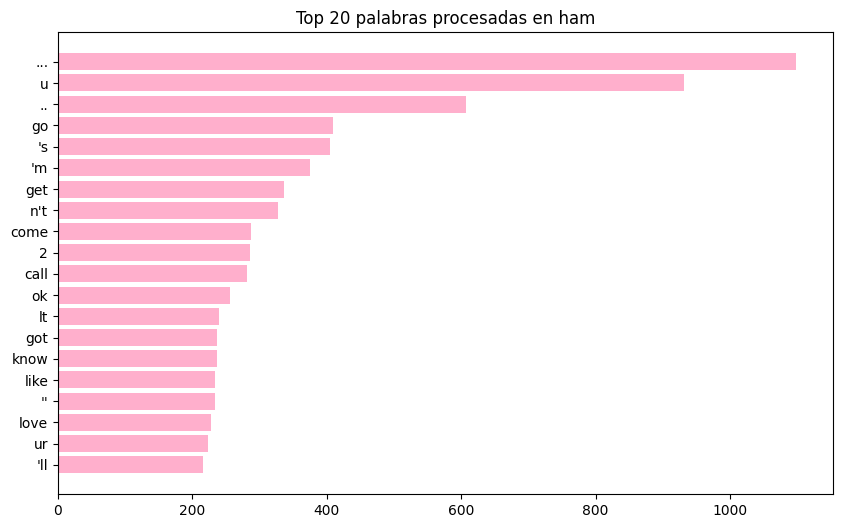

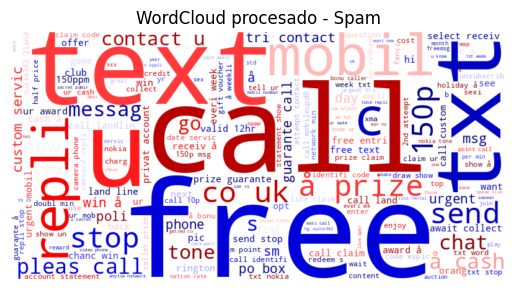

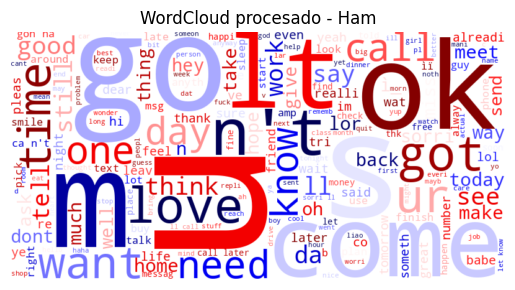

In [46]:
#densidad de longitud de cada mensaje
df['Length'] = df['Processed_Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['Label'] == 'spam'], x='Length', color='#ffafcc', label='SPAM', fill=True)
sns.kdeplot(data=df[df['Label'] == 'ham'], x='Length', color='#a2d2ff', label='HAM', fill=True)
plt.title('Distribución de longitud de mensajes - Spam vs Ham', fontsize=14)
plt.xlabel('Longitud del mensaje', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Tipo de mensaje', title_fontsize=12, fontsize=11)
plt.show()

# top 20
plot_top_words(df[df['Label'] == 'spam']['Processed_Text'], 'Top 20 palabras procesadas en spam')
plot_top_words(df[df['Label'] == 'ham']['Processed_Text'], 'Top 20 palabras procesadas en ham')

#wordcloud
generate_wordcloud(' '.join(df[df['Label'] == 'spam']['Processed_Text']), 'WordCloud procesado - Spam')
generate_wordcloud(' '.join(df[df['Label'] == 'ham']['Processed_Text']), 'WordCloud procesado - Ham')

# Modelo

In [ ]:
# entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Text'], df['Label'], test_size=0.2, random_state=42)

In [ ]:
#vectorización de texto
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Modelo bayesiano naive

In [49]:
class NaiveBayesSpamClassifier:
    def __init__(self):
        self.spam_prob = None
        self.ham_prob = None
        self.spam_word_probs = {}
        self.ham_word_probs = {}
    
    def fit(self, X, y):
        # Calcular probabilidades a priori
        total = len(y)
        self.spam_prob = (y == 'spam').sum() / total
        self.ham_prob = 1 - self.spam_prob
        
        # Contar palabras en spam y ham
        spam_word_counts = {}
        ham_word_counts = {}
        vocab = set()
        
        for text, label in zip(X, y):
            words = text.split()
            for word in words:
                vocab.add(word)
                if label == 'spam':
                    spam_word_counts[word] = spam_word_counts.get(word, 0) + 1
                else:
                    ham_word_counts[word] = ham_word_counts.get(word, 0) + 1
        
        # Calcular probabilidades condicionales con suavizado de Laplace
        vocab_size = len(vocab)
        total_spam_words = sum(spam_word_counts.values()) + vocab_size
        total_ham_words = sum(ham_word_counts.values()) + vocab_size
        
        for word in vocab:
            self.spam_word_probs[word] = (spam_word_counts.get(word, 0) + 1) / total_spam_words
            self.ham_word_probs[word] = (ham_word_counts.get(word, 0) + 1) / total_ham_words
    
    def predict_proba(self, text, threshold=0.5):
        words = text.split()
        p_spam = self.spam_prob
        p_ham = self.ham_prob
        
        for word in words:
            if word in self.spam_word_probs:
                p_spam *= self.spam_word_probs[word]
                p_ham *= self.ham_word_probs[word]
        
        # Evitar división por cero
        if p_spam + p_ham == 0:
            return 0.0
        
        prob_spam = p_spam / (p_spam + p_ham)
        return prob_spam
    
    def predict(self, text, threshold=0.5):
        prob = self.predict_proba(text, threshold)
        return 'spam' if prob >= threshold else 'ham'

In [50]:
# Entrenar el modelo
nb_classifier = NaiveBayesSpamClassifier()
nb_classifier.fit(X_train, y_train)

# Evaluación del modelo

In [51]:
nb_classifier = NaiveBayesSpamClassifier()
nb_classifier.fit(X_train, y_train)

# 6. Evaluación del modelo
def evaluate_model(classifier, X_test, y_test, threshold=0.5):
    y_pred = [classifier.predict(text, threshold) for text in X_test]
    
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nPrecisión: {accuracy:.4f}")

In [52]:
evaluate_model(nb_classifier, X_test, y_test)


Matriz de confusión:
[[952   3]
 [ 13 145]]

Reporte de clasificación:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       955
        spam       0.98      0.92      0.95       158

    accuracy                           0.99      1113
   macro avg       0.98      0.96      0.97      1113
weighted avg       0.99      0.99      0.99      1113


Precisión: 0.9856


## Para ingresar texto y que el modelo lo clasifique

In [53]:
while True:
    text = input("\nIngrese un mensaje para clasificar (o 'salir' para terminar): ")
    if text.lower() == 'salir':
        break
    print("\n------------------------------------------------------------------------")
    print(f"Message received: {text}")
    
    processed_text = preprocess_text(text)
    prob = nb_classifier.predict_proba(processed_text)
    
    print(f"\nProbabilidad de ser SPAM: {prob:.4f}")
    print(f"Clasificación: {'SPAM' if prob >= 0.5 else 'HAM'}")
    
    # Mostrar las 3 palabras con mayor poder predictivo de SPAM
    words = processed_text.split()
    word_probs = []
    
    for word in words:
        if word in nb_classifier.spam_word_probs:
            spam_prob = nb_classifier.spam_word_probs[word]
            ham_prob = nb_classifier.ham_word_probs[word]
            if ham_prob > 0:  # Evitar división por cero
                ratio = spam_prob / ham_prob
                word_probs.append((word, ratio))
    
    word_probs.sort(key=lambda x: x[1], reverse=True)
    top_words = word_probs[:3]
    
    if top_words:
        print("\nTop 3 palabras con mayor poder predictivo de SPAM:")
        for word, ratio in top_words:
            print(f"- {word} (ratio: {ratio:.2f})")